A basic implementation of ACR GNNs and some experimental evaluations. Much of this is made for experiments with the synthetic datasets provided by Barcelo et al., found at https://github.com/juanpablos/GNN-logic

In [2]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing,global_add_pool
from torch_geometric.data import Data

import matplotlib.pyplot as plt

import pickle

import sys
sys.path.append("GNN-logic/src")

import utils
from utils import util

# from primulautils import datatordef
from torch_geometric.data import DataLoader

import os


ModuleNotFoundError: No module named 'torch_sparse'

In [2]:
def sigma(x):
    return 1/(1+np.exp(-x))

def onehot(y):
    oh=torch.zeros((len(y),torch.max(y)+1))
    for i in range(len(y)):
        oh[i,y[i]]=1
    return oh


def prediction(x):
    if x>0.5:
        return 1
    return 0


In [3]:
class MYConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add',flow="source_to_target")
        self.lin=torch.nn.Linear(in_channels, out_channels, bias=False)
        
    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        # linear transformation of input features 
        x = self.lin(x)
        
        return self.propagate(edge_index, x=x)
       
class MYACRConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add',flow="source_to_target")
        # Only one of the linear components needs a bias, since otherwise would
        # just end up with the sum of the three biases
        self.ic=in_channels
        self.oc=out_channels
        self.A=torch.nn.Linear(in_channels, out_channels, bias=False)
        self.R=torch.nn.Linear(in_channels, out_channels, bias=False)
        self.C=torch.nn.Linear(in_channels, out_channels, bias=False)
        self.b=torch.nn.Parameter(torch.rand(self.oc))
       
    def forward(self, x, edge_index, batch):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        #Uncomment the following if no batches are defined
        #batch=torch.zeros(x.shape[0],dtype=torch.int64)
        r = global_add_pool(x,batch)
        
        # linear transformation of readout 
        r=self.R(r)
        #print("r after linear: {}".format(r))
        # reshapes to (numnodes x features) matrix (with identical rows):
        r = r[batch]
        
        # linear transformation of neighbor features 
        messages = self.A(x)
        
        # linear transformation of own features
        private = self.C(x)
        
        #print("batch: {}".format(batch))
        
        #print("r computed: {}".format(r))
        
#         self.propagate(edge_index, size=None, **kwargs):
#         The initial call to start propagating messages. Takes in the 
#         edge indices and all additional data which is needed to construct 
#         messages and to update node embeddings. 
        
        return private + self.propagate(edge_index, x=messages, readout=r)
    
    
    
#         Updates node embeddings for each node . 
#         Takes in the output of aggregation as first argument and any 
#         argument which was initially passed to propagate().
    def update(self,x,readout):

    #print("update for x= {} and \n r = {}".format(x,readout))
        return nn.functional.sigmoid(x+readout+self.b)
    
    def init(self):
        self.A.weight.data.uniform_(-1,1)
        self.R.weight.data.uniform_(-1,1)
        self.C.weight.data.uniform_(-1,1)
        self.b.data.uniform_(-1,1)

In [4]:
class MYACRGnn(nn.Module):
    def __init__(self,dims):
        super().__init__()
        #self.layers=nn.Sequential()
        self.layers=torch.nn.ModuleList()
        for d in range(len(dims)-2):
            self.layers.append(MYACRConv(dims[d],dims[d+1]))
        
        self.layers.append(nn.Linear(dims[-2],dims[-1],bias=True))
        self.layers.append(nn.Sigmoid())
        
    def forward(self,x,graph,batch):
        h=x
        for i in range(len(self.layers)):
            l=self.layers[i]  
            if type(l)==MYACRConv:
                h=l.forward(h,graph,batch)
            else:
                h=l.forward(h)
        return h
    
    def init(self):
        for i in range(len(self.layers)):
            l=self.layers[i] 
            if type(l)==MYACRConv:
                l.init()
            if type(l)==nn.Linear:
                l.weight.data.uniform_(-1,1)
                l.bias.data.uniform_(-1,1)
        
        
    def printparameters(self):
        print("0.A: {}".format(self.layers[0].A.weight.data))
        print("0.R: {}".format(self.layers[0].R.weight.data))

        print("1 weights: {}".format(self.layers[1].weight.data))
        print("1 bias: {}".format(self.layers[1].bias.data))

        print("3 weights: {}".format(self.layers[3].weight.data))
        print("3 bias: {}".format(self.layers[3].bias.data))
        
    def exportparameters(self,filepath):  
        weights =[]
        biases = []
        
        for i in range(len(self.layers)):
            if type(self.layers[i])==MYACRConv:
                wdic={'A':self.layers[i].A.weight.data,'R':self.layers[i].R.weight.data,'C':self.layers[i].C.weight.data,}
                weights.append(wdic)
                biases.append(self.layers[i].b.data)
            if type(self.layers[i])==nn.Linear:
                weights.append(self.layers[i].weight.data)
                biases.append(self.layers[i].bias.data)
        pickle.dump({'weights':weights,'biases':biases}, open( filepath+'.p', "wb" ) )
        
    def loadparameters(self,filepath):
        # loads parameters from file generated by exportparameters
        params=pickle.load(open(filepath,"rb"))
        weights=params['weights']
        biases=params['biases']
        for i in range(len(self.layers)):
            if type(self.layers[i])==MYACRConv:
                wdic=weights[i]
                self.layers[i].A.weight.data=wdic['A']
                self.layers[i].R.weight.data=wdic['R']
                self.layers[i].C.weight.data=wdic['C']
                self.layers[i].b.data=biases[i]
            if type(self.layers[i])==nn.Linear:
                self.layers[i].weight.data=weights[i]
                self.layers[i].bias.data=biases[i]

Manual setting of parameters for the alpha1-[4] model (both just count the number of blue nodes):

In [ ]:
model.layers[0].A.weight.data=torch.tensor([[-9.0,0.0,0.0,0.0,0.0],[9.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0]])
model.layers[0].R.weight.data=torch.tensor([[9.0,0.0,0.0,0.0,0.0],[-9.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0]])
model.layers[0].C.weight.data=torch.tensor([[0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0]])
model.layers[0].b.data=torch.nn.Parameter(torch.tensor([-69.0,96.0,0.0,0.0]))


model.layers[1].weight.data=torch.tensor([[9.0,9.0,0.0,0.0]])
model.layers[1].bias.data=torch.tensor([[-13.0]])

In [ ]:
model.layers[0].A.weight.data=torch.tensor([[1.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0]])
model.layers[0].R.weight.data=torch.tensor([[0.0,0.0,0.0,0.0,0.0],[1.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0]])
model.layers[0].C.weight.data=torch.tensor([[0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0]])
model.layers[0].A.bias.data=torch.tensor([0.0,0.0,0.0,0.0])

model.layers[2].weight.data=torch.tensor([[-9.0,9.0,0.0,0.0],[9.0,-9.0,0.0,0.0]])
model.layers[2].bias.data=torch.tensor([[-69.0,96,0.0,0.0]])

model.layers[3].weight.data=torch.tensor([[-9.0,-9.0],[9.0,9.0]])
model.layers[3].bias.data=torch.tensor([[12.0,-13.0]])

Reading parameters from stored pickle file

In [ ]:
alpha=1
dims=(5,4,1)

basedir = 'GraphNN-develop/'
savedir = basedir + 'Alpha'+str(alpha)+'-learned-params-'+str(dims)+ '/'

file='params-epoch190.p'

picklefile=savedir+file

params=pickle.load(open(picklefile,"rb"))

#### Testing on tiny graph

In [ ]:
edge_index=torch.tensor([[0,1,2],[2,2,3]])
x=torch.tensor([[0.0,1.0,0.0],[0.0,1.0,0.0],[1.0,0.0,0.0],[0.0,0.0,1.0]])
batch=torch.tensor([0,0,0,0],dtype=torch.long)

model=MYACRGnn(3,3)

model.layers[0].A.weight.data=torch.tensor([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]])
model.layers[0].R.weight.data=torch.tensor([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
model.layers[0].C.weight.data=torch.tensor([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]])



model(x,edge_index,batch)

### Setting up the experiment

In [21]:
alpha = 1
dims = (5,4,1)

model=MYACRGnn(dims)
model.init()

In [58]:
basedir = 'GraphNN-develop/'

datadir = basedir + 'GNNdata/p' + str(alpha)+ '/'



datastem="train-random-erdos-5000-40-50"
datafile= datastem+".txt"

data_train,_=util.load_data(
                     dataset=datadir+datafile,
                     degree_as_node_label=False)
#returns list of torch_geometric.data.data.Data (list item = one graph)


datastem_2="barabasi_albert_15_20_n5000"
datafile=datastem_2+".p"
data_2=pickle.load(open(datadir+datafile,"rb"))
for d in data_2:
    d.graph_label=torch.tensor([1]) # for compatibility with ACR data loaded 
    
data_train = data_train + data_2


datastem = datastem +"+" + datastem_2

loader = DataLoader(data_train,batch_size=50, shuffle=True)
print("Number of batches: {}".format(len(loader)))


Loading data...
#Graphs: 5000
#Graphs Labels: 2
#Node Features: 5
#Node Labels: 2
Number of batches: 200


In [49]:
# data,_=util.load_data(
#                      dataset=datadir+datafile,
#                      degree_as_node_label=False)
#returns list of torch_geometric.data.data.Data (list item = one graph)

data=pickle.load(open(datadir+datafile,"rb"))
loader = DataLoader(data,batch_size=50, shuffle=True)
print("Number of batches: {}".format(len(loader)))



Number of batches: 100


Main learning loop

Epoch: 0  Loss: 213756.65631103516  Accuracy: 0.5450533425435566
Epoch: 1  Loss: 204899.59912109375  Accuracy: 0.5889458131859697
Epoch: 2  Loss: 167992.67987060547  Accuracy: 0.7817848645329649
Epoch: 3  Loss: 127198.146484375  Accuracy: 0.8557065008826464
Epoch: 4  Loss: 109560.18801879883  Accuracy: 0.8633145291273313
Epoch: 5  Loss: 100701.86605834961  Accuracy: 0.8675518714662164
Epoch: 6  Loss: 94853.29440307617  Accuracy: 0.8729820656484253
Epoch: 7  Loss: 89684.99237060547  Accuracy: 0.8771938240335662
Epoch: 8  Loss: 86547.40661621094  Accuracy: 0.8811305549159567
Epoch: 9  Loss: 83675.42358398438  Accuracy: 0.8850417018446031
Epoch: 10  Loss: 80738.46224975586  Accuracy: 0.8896148335763809
Epoch: 11  Loss: 77561.76580810547  Accuracy: 0.8943702509785862
Epoch: 12  Loss: 76216.18432617188  Accuracy: 0.8974051474914934
Epoch: 13  Loss: 73528.44567871094  Accuracy: 0.9018599534372042
Epoch: 14  Loss: 71204.9967956543  Accuracy: 0.9056399826029115
Epoch: 15  Loss: 68618.707977294

Epoch: 149  Loss: 1.4035044265910983  Accuracy: 1.0
Epoch: 150  Loss: 1.387161549180746  Accuracy: 1.0
Epoch: 151  Loss: 1.3719533560797572  Accuracy: 1.0
Epoch: 152  Loss: 1.3586433953605592  Accuracy: 1.0
Epoch: 153  Loss: 1.343324039131403  Accuracy: 1.0
Epoch: 154  Loss: 1.3299379497766495  Accuracy: 1.0
Epoch: 155  Loss: 1.3155591669492424  Accuracy: 1.0
Epoch: 156  Loss: 1.3041484751738608  Accuracy: 1.0
Epoch: 157  Loss: 1.2910882863216102  Accuracy: 1.0
Epoch: 158  Loss: 1.279831557534635  Accuracy: 1.0
Epoch: 159  Loss: 1.2675916240550578  Accuracy: 1.0
Epoch: 160  Loss: 1.257267348933965  Accuracy: 1.0
Epoch: 161  Loss: 1.2421636115759611  Accuracy: 1.0
Epoch: 162  Loss: 1.2293244455941021  Accuracy: 1.0
Epoch: 163  Loss: 1.2154874505940825  Accuracy: 1.0
Epoch: 164  Loss: 1.206068514380604  Accuracy: 1.0
Epoch: 165  Loss: 1.1840632767416537  Accuracy: 1.0
Epoch: 166  Loss: 1.1641207071952522  Accuracy: 1.0
Epoch: 167  Loss: 1.1445246352814138  Accuracy: 1.0
Epoch: 168  Loss:

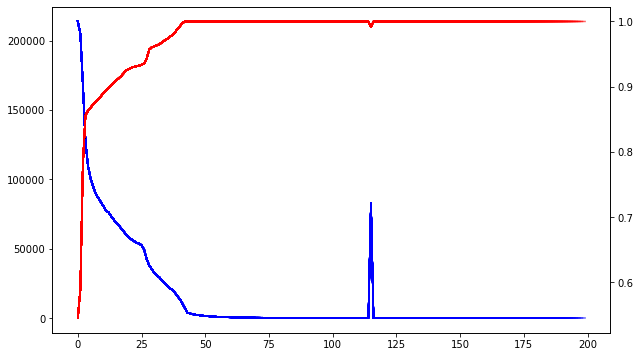

In [60]:
# Adam paper    Pytorch (with defaults)
# ======================================
# alpha         lr = 0.001
# beta1,beta2   betas=(0.9, 0.999)
# epsilon       eps=1e-08
#               weight_decay=0  (L2 regularization)

savedir = basedir + 'Alpha'+str(alpha)+'-learned-params-'+str(dims)+ '/' 
if not os.path.isdir(savedir):
    os.mkdir(savedir)
savedir = savedir + datastem+ '/'
if not os.path.isdir(savedir):
    os.mkdir(savedir)


filestem = 'params-'

optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)



# print("Initial parameters: ")
# model.printparameters()
loss=nn.BCELoss(reduction='sum')

#loss=nn.BCEWithLogitsLoss()

restarts=1
epochs=200

fig,axes = plt.subplots(1,1,figsize=(10,6))
rightax=axes.twinx()

allepochloss=np.zeros((restarts,epochs))
allepochacc=np.zeros((restarts,epochs))



for r in range(restarts):
    model.init()
    model.train() #not clear whether anything happens here
    
    allloss=[]
    allacc=[]

    bestloss = math.inf
    
    for epoch in range(epochs):
        t=0 # count of true predictions
        f=0 # count of false predictions
        epochloss=0
        for batch in loader:
            optimizer.zero_grad()
            out = model(batch.x,batch.edge_index,batch.batch)
            target = batch.node_labels
            
            # for BCE loss and one-hot label encoding:
            # ohtarget = onehot(batch.node_labels) 
            
            pred=np.vectorize(prediction)(out.detach()).reshape([-1])

            tt=len(np.where(np.array(target)==pred)[0])
            t+= tt
            f+= len(target)-tt

            l = loss(out.reshape([-1]),target.float())

            epochloss+=l.detach().item()
            l.backward()
            optimizer.step()
        #scheduler.step()
        allloss.append(epochloss)
        if epochloss < bestloss:
            bestloss = epochloss
            bestparams = model.state_dict()
        acc=t/(t+f)
        allacc.append(acc)
        allepochacc[r,epoch]=acc
        allepochloss[r,epoch]=epochloss
        print("Epoch: {}  Loss: {}  Accuracy: {}".format(epoch,epochloss,t/(t+f)))   
        
        # Save parameters of learned model every 10 epochs:
#         if epoch%10==0:
#             model.exportparameters(savedir+filestem+str(epoch)+"_l"+str(epochloss))
#         print("A grad: {}".format(model.layers[0].A.weight.grad))
#         print("bias: {}".format(model.layers[0].b.data))
#         print("bias grad: {}".format(model.layers[0].b.grad))
        axes.plot(allloss,c='b',alpha=0.6)
        rightax.plot(allacc,c='r',alpha=0.6)
        
    print(model.state_dict())   
    model.load_state_dict(bestparams)
    print(model.state_dict())   
    model.exportparameters(savedir+filestem+str(epoch)+"_l"+str(bestloss))
    print("final accuracy: {}".format(acc))    
    
# fig,axes = plt.subplots(1,1)
# rightax=axes.twinx()
# # axes.plot(allloss,c='r')
# rightax.plot(allacc,c='b')

plt.show()

#model.printparameters()

In [ ]:
savedat32d={'loss':allepochloss,'accuracy':allepochacc}
print(savedir)

pickle.dump(savedat32d, open( savedir+'loss-acc-alpha2-dim32-32-200epoch-3restarts.p',\
                          "wb" ) )

In [ ]:
savedir2='GraphNN-develop/Alpha1-learned-params-(5, 2, 1)/'
savedir8='GraphNN-develop/Alpha1-learned-params-(5, 8, 1)/'
#savedir64='GraphNN-develop/Alpha2-learned-params-(5, 64, 64, 1)/'

d2=pickle.load(open(savedir2 + 'loss-acc-alpha1-dim2-200epoch.p','rb'))
d8=pickle.load(open(savedir8 + 'loss-acc-alpha1-dim8-200epoch.p','rb'))
#d64=pickle.load(open(savedir64 + 'loss-acc-alpha2-dim64-64-300epoch.p','rb'))

### Testing

### A: setting up the model

In [94]:
alpha = 1
dims = (5,4,1)

model=MYACRGnn(dims)

# Getting saved parameters:

basedir = 'GraphNN-develop/'
savedir = basedir + 'Alpha'+str(alpha)+'-learned-params-'+str(dims)+ '/'
savedir = savedir + "train-random-erdos-5000-40-50+barabasi_albert_15_20_n5000/"

file='params-199_l0.22311485500540584.p'

picklefile=savedir+file

model.loadparameters(picklefile)

### B: setting up test data

In [95]:
# Reading a ACR dataset:

# datafile="test-random-erdos-500-51-60.txt"
# datadir = basedir + 'GNNdata/p' + str(alpha)+ '/'

# data_test,_=util.load_data(
#                      dataset=datadir+datafile,
#                      degree_as_node_label=False)


#Reading a Pickle file:

#datafile="barabasi_albert_15_20_n500.p"
datafile="blue_clique_6_15_n10.p"
datadir = basedir + 'GNNdata/p' + str(alpha)+ '/'

data_test=pickle.load(open(datadir+datafile,"rb"))


In [96]:
loader = DataLoader(data_test,batch_size=1, shuffle=True)

print("Number of batches: {}".format(len(loader)))

Number of batches: 10


### C: doing the test

In [97]:

t=0
f=0

loss=nn.BCELoss(reduction='sum')
l=0

for batch in loader:
    
    out = model(batch.x,batch.edge_index,batch.batch)
    target = batch.node_labels
    l+=loss(out.reshape([-1]),target.float())
    
    pred=torch.tensor(np.vectorize(prediction)(out.detach()).reshape([-1]))

    tt=len(torch.where(target==pred)[0])
    t+= tt
    f+= len(target)-tt

    #print("n: {}".format(batch.x.shape[0]))
    #print("Batch Accuracy: {}".format(tt/len(target)))   

print("Accuracy: {}  Loss: {}".format(t/(t+f),l))


Accuracy: 1.0  Loss: 0.012574378401041031


### [End clean code]

In [ ]:
type(onedata[0])

In [ ]:
learncurves=pickle.load(open('GraphNN-develop/alpha1-[4]-pytorch-200epochrun.p', \
                             "rb" ) )
trainacc=learncurves['accuracy']

plt.plot(range(200),trainacc[0],c='r',label="train")
plt.plot(same_accs[1:,0],same_accs[1:,1],c='b',label="test")
#plt.plot(larger_accs[1:,0],larger_accs[1:,1],c='g',label="test-larger")

plt.legend()
plt.ylim(0.999,1.0)
plt.xlim(49,60)
plt.show()

In [ ]:
print(type(data))
print(type(onedata))

print(type(data[0]))
print(type(onedata[0]))
print(type(gdata))


From https://gist.github.com/yang-zhang/09460d9e90a1bf29fb6edf121865df86#file-binary_cross_entropy_with_logits-ipynb

In [ ]:
def sigmoid(x): return (1 + (-x).exp()).reciprocal()
def binary_cross_entropy(input, y): return -(pred.log()*y + (1-y)*(1-pred).log()).mean()

pred = sigmoid(x)
loss = binary_cross_entropy(pred, y)
loss


In [ ]:
pred = torch.sigmoid(x)
loss = F.binary_cross_entropy(pred, y,reduction='none')
loss


In [ ]:
pred

In [ ]:
F.binary_cross_entropy_with_logits(x, y)

# Graph sampler

In [74]:
import networkx as nx

#### Barabasi Albert graphs:

In [125]:
nmin=40
nmax=50

N=5000



b_a_data=[]
totaln=0
totalpos=0

for s in range(N):
    n=np.random.randint(nmin,nmax+1)
    totaln+=n
    
    graph = nx.barabasi_albert_graph(n, 3)

    x=torch.zeros((n,5))
    blueprob=0.2

    # assign blue color:
    for i in range(n):
        if np.random.random()<blueprob:
            x[i,0]=1

    # assign other colors (uniform):
    for j in np.where(x[:,0]!=1)[0]:
        k=np.random.randint(1,high=5)
        x[j,k]=1

    numblues = torch.sum(x[:,0])  
    blueneighbs = torch.zeros(n)

    for e in graph.edges:
        if x[e[1],0]==1:
            blueneighbs[e[0]]+=1
        if x[e[0],0]==1:
            blueneighbs[e[1]]+=1

    node_labels=torch.zeros(n)
    numpos=0

    for i in range(n):
        l = numblues-blueneighbs[i]
        if l>=8 and l<=10:
            node_labels[i]=1
            numpos+=1
    
    totalpos+=numpos

    ne = len(graph.edges)
    edge_index=torch.zeros((2,2*ne),dtype=torch.long)

    for i,e in enumerate(graph.edges):
        edge_index[:,i]=torch.tensor(e)
        edge_index[:,ne+i] = torch.tensor(tuple(reversed(e)))


    b_a_data.append(Data(x=x,edge_index=edge_index,node_labels=node_labels))
  
print("positive rate: {}".format(totalpos/totaln))

positive rate: 0.3669602016367427


In [126]:
basedir = 'GraphNN-develop/'

savedir = basedir + "GNNdata/p1/"

outfilebase="barabasi_albert_"+str(nmin)+"_"+str(nmax)+"_n" + str(N)
outfilerdef=outfilebase+".rdef"
outfilep=outfilebase+".p"



In [127]:
pickle.dump(b_a_data,open(savedir+outfilep,"wb"))

In [128]:
#datatordef(b_a_data,savedir,outfilerdef,1.0,"alpha1",True)

Ensure that alpha1 is the class specified in preamble.txt!


#### Blue clique graphs:

In [83]:
# Create graphs consisting of a clique of size B and n-B nodes without any edges
# all nodes in the clique are colored blue, and all other nodes not blue

n=25
Bmin=6 
Bmax=15

N=10



bclique_data=[]

totaln=0
totalpos=0

for s in range(N):
    B=np.random.randint(Bmin,Bmax+1)
    
    graph = nx.complete_graph(B)
    for i in range(n-B):
        graph.add_node(B+i)
  
    x=torch.zeros((n,5))
    

    # assign blue color:
    for i in range(B):
            x[i,0]=1

    # assign other colors (uniform):
    for i in range(n-B):
        k=np.random.randint(1,high=5)
        x[B+i,k]=1

    numblues = torch.sum(x[:,0])  
    blueneighbs = torch.zeros(n)

    for e in graph.edges:
        if x[e[1],0]==1:
            blueneighbs[e[0]]+=1
        if x[e[0],0]==1:
            blueneighbs[e[1]]+=1

    node_labels=torch.zeros(n)
    numpos=0

    for i in range(n):
        l = numblues-blueneighbs[i]
        if l>=8 and l<=10:
            node_labels[i]=1
            numpos+=1
    
    totalpos+=numpos

    ne = len(graph.edges)
    edge_index=torch.zeros((2,2*ne),dtype=torch.long)

    for i,e in enumerate(graph.edges):
        edge_index[:,i]=torch.tensor(e)
        edge_index[:,ne+i] = torch.tensor(tuple(reversed(e)))

    graph_label=torch.tensor([1])
    bclique_data.append(Data(x=x,edge_index=edge_index,node_labels=node_labels,graph_label=graph_label))
  
print("positive rate: {}".format(totalpos/(n*N)))

positive rate: 0.252


In [84]:
basedir = 'GraphNN-develop'

savedir = basedir + "GNNdata/p1/"

outfilebase="blue_clique_"+str(Bmin)+"_"+str(Bmax)+"_n" + str(N)
outfilerdef=outfilebase+".rdef"
outfilep=outfilebase+".p"



In [86]:
pickle.dump(bclique_data,open(savedir+outfilep,"wb"))
#datatordef(bclique_data,outfilerdef,1.0,"alpha1",True)

Ensure that alpha1 is the class specified in preamble.txt!


NameError: name 'dirpath' is not defined

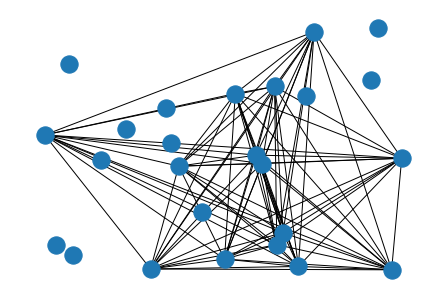

In [80]:
nx.draw_random(graph)

In [103]:
bclique_data[4].node_labels

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.])